# Data Cleaning Notebook - PureGraph Size Comparison

Load the necessary packages and modules.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

sns.set_theme('paper',font_scale=1.5)
sns.set_style('white')

from modules.data_visualisation import plot_single_fit
from modules.data_cleaning import clean_outliers, sample_spectra

## Import Data

Import the pickled data from (1).

In [2]:
data = pd.read_pickle(Path.cwd().joinpath('data','input','puregraph_size_comparison.pkl'))
data = data.fillna(0)
data = data.reset_index(drop=True) 

Extract details from the filename and peak fittings.

In [3]:
data['peaks']               = data.model.str.extractall(r"prefix=.([a-zA-Z0-9_]*)_").groupby(level=0)[0].apply(list)
data['material']            = data['file'].str.extract(r'^([a-zA-Z0-9]*)_')
data['functionalisation']   = data['file'].str.extract(r'^[a-zA-Z0-9]*_([a-zA-Z0-9]*)_')
data['map']                 = data['file'].str.extract(r'([0-9]).pkl').astype(int)

Find peak ratios.

In [4]:
data["Par_DG_IDG"]  = data["Par_D_height"]      / data["Par_G_height"]
data["Par_DG_ADG"]  = data["Par_D_amplitude"]   / data["Par_G_amplitude"]

data["Par_D2G_IDG"] = data["Par_D2_height"]     / data["Par_G_height"]
data["Par_D2G_ADG"] = data["Par_D2_amplitude"]  / data["Par_G_amplitude"]

data["Par_D2G_FDG"] = data["Par_D2_fwhm"]     / data["Par_G_fwhm"]
data["Par_DG_FDG"]  = data["Par_D_fwhm"]      / data["Par_G_fwhm"]

Read in x-axis data.

In [5]:
x = pd.read_csv(Path.cwd().joinpath('data','input','generic_x_puregraph.csv'), header=None)
x = x.to_numpy().reshape(len(x))

## Clean Data

Filter the dataframe to remove peak fitting issues. 
- D peak overfit
- D' peak replaces G peak

In [6]:
data_clean_1 = data.loc[data['Par_D_fwhm'].astype(float)< 130]
data_clean_1 = data_clean_1.loc[data_clean_1['Par_Dd_amplitude']<data_clean_1['Par_G_amplitude']]
data_clean_1.groupby(['material','map']).count()['spectrum']

material  map
PG10      1      568
          2      570
          3      556
PG20      1      480
          2      428
          3      481
PG5       1      477
          2      540
          3      454
Name: spectrum, dtype: int64

Remove outliers 1.5x over/under the IQR.

In [7]:
data_clean_2 = clean_outliers(
    df_in               = data_clean_1,
    group_columns       =['material'],
    fit_features        = [
        'Par_DG_IDG',
        'Par_DG_ADG',
        'Par_D2G_IDG',
        'Par_D2G_ADG',
        'Par_DG_FDG',
        'Par_D2G_FDG',
        'Par_G_center',
        'Par_D2_center',
        'Par_D_center'
        ],
    extent_multiplier   = 1.5)

data_clean_2.groupby(['material']).count()['spectrum']

material
PG10    1320
PG20    1012
PG5     1029
Name: spectrum, dtype: int64

Make final number of spectra consistent (500)

In [8]:
data_clean_2_sample = sample_spectra(
    data_clean_2,
    ['material'],
    1000
)

data_clean_2_sample.groupby(['material']).count()['spectrum']

material
PG10    1000
PG20    1000
PG5     1000
Name: spectrum, dtype: int64

## Plot

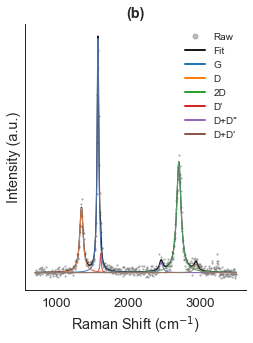

In [9]:
fig, ax = plot_single_fit(
    data.loc[data['material']=='PG20'],
    4532,
    x,
    background_poly = 4
)

custom_lines = [Line2D([0], [0], marker='o', color='tab:grey', label='Raw',
                          markerfacecolor='tab:grey', markersize=5,lw=0,alpha=0.5),
                Line2D([0], [0], color='k', lw=2,label='Fit'),
                Line2D([0], [0], color='tab:blue', lw=2,label='G'),
                Line2D([0], [0], color='tab:orange', lw=2,label = 'D'),
                Line2D([0], [0], color='tab:green', lw=2,label = '2D'),
                Line2D([0], [0], color='tab:red', lw=2,label = "D'"),
                Line2D([0], [0], color='tab:purple', lw=2,label = 'D+D"'),
                Line2D([0], [0], color='tab:brown', lw=2,label = "D+D'"),
                ]

plt.legend(handles= custom_lines,frameon=False,loc='upper right',fontsize=10)
plt.xlabel('Raman Shift (cm$^{-1}$)')
plt.ylabel('Intensity (a.u.)')
plt.title('(b)',fontweight='bold')
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(Path.cwd().joinpath('figures','Figure 3 (b).png'),dpi=300)

In [10]:
main_paramaters = ['Par_G_center','Par_G_fwhm','Par_G_amplitude','Par_G_height',
                   'Par_D_center','Par_D_fwhm','Par_D_amplitude','Par_D_height',
                   'Par_D2_center','Par_D2_fwhm','Par_D2_amplitude','Par_D2_height',
                   'Par_DG_IDG','Par_DG_ADG','Par_D2G_IDG','Par_D2G_ADG',
                   ]

parameters = data_clean_2_sample[['material','functionalisation','map','spectrum']+ main_paramaters].reset_index(drop=True)

parameters_melt = parameters.melt(
    id_vars = ['material','map','spectrum'],
    value_vars = parameters.columns[2:]
)

parameters_melt['measure'] = parameters_melt['variable'].str.extract(r'_([a-zA-Z]*)$')
parameters_melt['peak'] = parameters_melt['variable'].str.extract(r'_([a-zA-Z0-9_]*)_[a-zA-Z]*$')

# 1) IDG - position
parameters_melt.loc[
    (parameters_melt['peak'] == 'DG') & (parameters_melt['measure'] == 'IDG'),
    'measure'
] = 'center'

# 2) ADG - FWHM
parameters_melt.loc[
    (parameters_melt['peak'] == 'DG') & (parameters_melt['measure'] == 'ADG'),
    'measure'
] = 'fwhm'

# 3) I2DG - Area
parameters_melt.loc[
    (parameters_melt['peak'] == 'D2G') & (parameters_melt['measure'] == 'IDG'),
    'measure'
] = 'amplitude'

# 4) I2DG - Intensity
parameters_melt.loc[
    (parameters_melt['peak'] == 'D2G') & (parameters_melt['measure'] == 'ADG'),
    'measure'
] = 'height'

# Switch to Same Row

parameters_melt.loc[
    (parameters_melt['peak'] == 'D2G'),
    'peak'
] = 'DG'

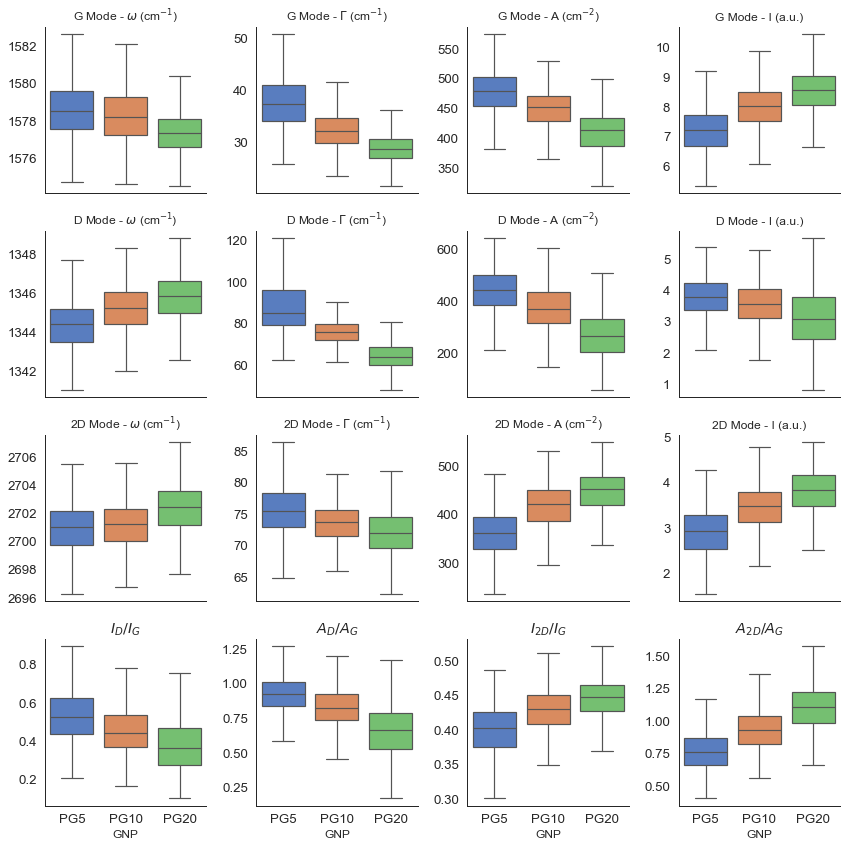

In [11]:
clean_up_dict = {
    'D2':'2D',
    'G':'G',
    'D':'D',
    'G_D':'G+D',
    'DG': 'DG',
    'ADG':'ADG',
    'IDG':'IDG',
    'ADG2': 'ADG',
    'IDG2':'IDG',
    'center':'$\omega$ (cm$^{-1}$)',
    'fwhm': '$\Gamma$ (cm$^{-1}$)',
    'height': 'I (a.u.)',
    'amplitude': 'A (cm$^{-2}$)'
}

graph = sns.catplot(
    data = parameters_melt,
    x = 'material',
    order = ['PG5','PG10','PG20'],
    hue_order = ['PG5','PG10','PG20'],
    y = 'value',
    hue = 'material',
    legend_out=True,
    col = 'measure',
    row = 'peak',
    palette = 'muted',
    kind='box',
    sharey=False,
    dodge = False,
    showfliers= False,
    height = 3,
)


for (row_key, col_key),ax in graph.axes_dict.items():
    ax.set_title(f"{clean_up_dict[row_key]} Mode - {clean_up_dict[col_key]}",fontsize=12)
    ax.set_ylabel('',fontsize=12)
    ax.set_xlabel('GNP',fontsize=12)
    
    
graph.axes.flatten()[12].set_title('$I_D/I_G$')
graph.axes.flatten()[13].set_title('$A_D/A_G$')
graph.axes.flatten()[14].set_title('$I_{2D}/I_G$')
graph.axes.flatten()[15].set_title('$A_{2D}/A_G$')



plt.tight_layout()
plt.savefig(Path.cwd().joinpath('figures','Figure 4.png'),dpi=300)
plt.show()


In [12]:
def average_group(group_in):
    
    item_sum = np.zeros(587)
    k= 0 
    
    for item in group_in['data']:
        
        item_sum = item + item_sum
        k = k +1
    
    
    avg_spectrum = item_sum/k
    
    return avg_spectrum
        
avg_spectra = data_clean_2_sample.groupby(['material','functionalisation']).apply(average_group).reset_index()
avg_spectra.columns = ['material','functionalisation','spectra']


def expand_spectra(group_in):
    df = pd.DataFrame({
        'intensity': group_in['spectra'].iloc[0],
        'x':x,
        })
    
    return df

avg_spectra2 = avg_spectra.groupby(['material','functionalisation']).apply(expand_spectra).reset_index(drop=False)
avg_spectra2 = avg_spectra2[['material','functionalisation','intensity','x']]

def scale_spectra(group_in):
    
    group_in['intensity_scaled'] = group_in['intensity']/group_in['intensity'].max()
    return group_in

avg_spectra3 = avg_spectra2.groupby(['material','functionalisation']).apply(scale_spectra).reset_index(drop=False)

offset_dict ={'PG5':1,
 'PG10':2,
 'PG20':3,}
 
def offset_spectra(group_in):
    group_in['intensity_offset'] = group_in['intensity_scaled'] + offset_dict[group_in['material'].iloc[0]]
    return group_in

avg_spectra4 = avg_spectra3.groupby(['material','functionalisation']).apply(offset_spectra).reset_index(drop=False)


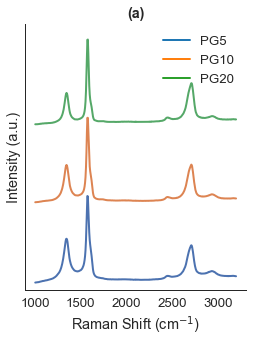

In [13]:
graph = sns.FacetGrid(
    data=avg_spectra4.loc[(avg_spectra4['x']>1000) & (avg_spectra4['x']<3200)],
    hue = 'material',
    hue_order = ['PG5','PG10','PG20'],
    height = 5,
    aspect = 3/4
)

def graph_lineplot(*args, **kwargs):
    
    data = kwargs.pop('data')
    data_in = data.loc[data['functionalisation']=='BL']
    
    if args[0] == True:
        kwargs['color'] = 'tab:purple'
        data_in = data.loc[data['functionalisation']=='CF4']
        data_in['intensity_offset'] = data_in['intensity_offset'] + 0.5
    
    sns.lineplot(
        data = data_in,
        x = 'x',
        y = 'intensity_offset',
        **kwargs,
        lw=2,
    )


graph.map_dataframe(graph_lineplot, False)

custom_lines = [
    Line2D([0], [0], color='tab:blue', lw=2,label='PG5'),
    Line2D([0], [0], color='tab:orange', lw=2,label = 'PG10'),
    Line2D([0], [0], color='tab:green', lw=2,label = 'PG20'),
                ]

plt.legend(handles= custom_lines,frameon=False,loc='upper right')
plt.xlabel(r'Raman Shift (cm$^{-1}$)')
plt.ylabel(r'Intensity (a.u.)')
plt.title('(a)',fontweight='bold')
plt.yticks([])

plt.ylim(0.8,4.2)


plt.tight_layout()
plt.savefig(Path.cwd().joinpath('figures','Figure 3 (a).png'),dpi=300)
plt.show()

## Export Data

In [14]:
wide_data_export = data_clean_2_sample[[
    'material','map','functionalisation','spectrum',  
    'Par_G_height','Par_D_height','Par_D2_height',
    'Par_G_center','Par_G_fwhm','Par_G_amplitude',
    'Par_D_center','Par_D_fwhm','Par_D_amplitude',
    'Par_D2_center','Par_D2_fwhm','Par_D2_amplitude',
    'Par_DG_IDG','Par_DG_ADG',
    'Par_D2G_IDG','Par_D2G_ADG',
]].reset_index(drop=True)

In [15]:
wide_data_export.to_csv(
    Path.cwd().joinpath(
        'data',
        'output',
        'puregraph_size_comparison_cleaned.csv')
)